# Representation Learning using Auto Encoders

In [27]:
import tensorflow as tf
import keras as K
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.2.4
TensorFlow version: 2.13.1


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  1
GPU is available


In [4]:
def log_reg(train_images, train_labels, test_images, test_labels):
    # set up classifier model
    classifier_input = K.layers.Input(shape=(train_images.shape[1],))
    classifier_output = K.layers.Dense(10, activation='softmax')(classifier_input)
    classifier = K.Model(classifier_input, classifier_output)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # early stopping
    early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

    # training the classifier
    classifier.fit(train_images, train_labels, epochs=50, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping])

    # classifier's evaluation
    test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
    print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

def convergence(model, max_iter=100, n_img=10, conv=False):
    fig, axes = plt.subplots(1, n_img, figsize=(20, 2))

    for i in range(n_img):
        if conv:
            noise_image = np.random.normal(loc=0.5, scale=1., size=(1, 28, 28, 1))
        else:
            noise_image = np.random.normal(loc=0, scale=1, size=(1, 784))
        noise_image = np.clip(noise_image, 0., 1.)

        for _ in range(max_iter):
            noise_image = model.predict(noise_image, verbose=0)

        # Plot the denoised image
        ax = axes[i]
        ax.imshow(noise_image.reshape(28, 28), cmap='gray')
        ax.set_title(f"Image {i+1}")
        ax.axis('off')  # Hide axes ticks

    plt.show()



## Denoising Auto Encoder
In the following we are going to dive into DAEs to learn hidden representations of the MNIST dataset.

At first we will try with an auto-encoder of two layers of very small dimensions, that will get trained altogether. After that we are going to implement Greedy Unsupervised Layerwise Pretraining which will be used to train the same two layers used in the first instance, but once at a time –i.e. we train one layer to predict the noised data coming from the preceding layer (where the first layer will get the data as input). Afterwards, we'll also fine-tune the autoencoder to see if any improvement occurs.

### Data preprocessing

In [61]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

# add noise to images
noise_factor = 0.5
x_train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)
x_test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

train_labels = K.utils.to_categorical(train_labels, 10)
test_labels = K.utils.to_categorical(test_labels, 10)

### 2-layers Auto-Encoder

In [62]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
# encoder
encoded = K.layers.Dense(256, activation='relu')(input_img)
encoded = K.layers.Dense(128, activation='relu')(encoded)
# decoder
decoded = K.layers.Dense(256, activation='relu')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# early stopping
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)

# autoencoder's training
autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0, callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 31.
Epoch 36: early stopping


#### Classification score, reconstruction error and manifold convergence

In [63]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 28.
Epoch 33: early stopping
313/313 [==============================] - 0s 1ms/step - loss: 0.3992 - accuracy: 0.8745
Test accuracy: 0.8744999766349792, Test loss: 0.39919713139533997


In [64]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.014036096632480621


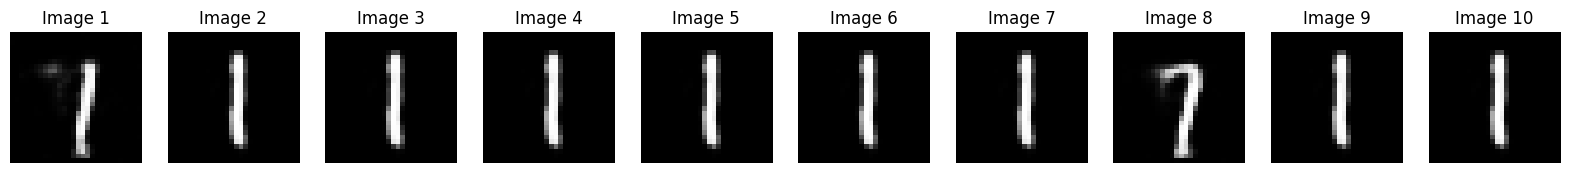

In [65]:
convergence(autoencoder)

random noise seems to be converging to digit 1 and digit 9 most of the time

### Greedy Unsupervised Layerwise Pretraining
As anticipated above, we are now implementing the GULP strategy to train deep autoencoders (each one composed of a single layer). In this case, given the simpplicity of the dataset we are going to use just two autoencoders (one with a layer of 256 units and one with a layer of 128, in order to match the structure of the previous built autoencoder).

In [10]:
# define the autoencoder structure
def create_autoencoder(input_size, encoding_dim):
    input_layer = K.layers.Input(shape=(input_size,))
    encoded = K.layers.Dense(encoding_dim, activation='relu')(input_layer)
    decoded = K.layers.Dense(input_size, activation='sigmoid')(encoded)
    autoencoder = K.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# layerwise pretraining
first_autoencoder = create_autoencoder(784, 256)
# early stopping
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
first_autoencoder.fit(x_train_noisy, x_train_noisy, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# get the encoder
first_encoder = K.Model(first_autoencoder.input, first_autoencoder.layers[1].output)
first_encoded_train = first_encoder.predict(x_train_noisy, verbose=0)

# adding noise to the hidden representation of the first autoencoder
first_encoded_train_noised = first_encoded_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=first_encoded_train.shape)
first_encoded_train_noised = np.clip(first_encoded_train_noised, 0., 1.)

second_autoencoder = create_autoencoder(256, 128)
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
second_autoencoder.fit(first_encoded_train_noised, first_encoded_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# stacking up the full autoencoder
input_img = K.layers.Input(shape=(784,))
first_encoded = first_autoencoder.layers[1](input_img)
second_encoded = second_autoencoder.layers[1](first_encoded)
second_decoded = second_autoencoder.layers[2](second_encoded)
first_decoded = first_autoencoder.layers[2](second_decoded)

autoencoder = K.Model(input_img, first_decoded)
encoder = K.Model(input_img, second_encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Restoring model weights from the end of the best epoch: 24.
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping


In [15]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 36.
Epoch 41: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 1.0762 - accuracy: 0.6394
Test accuracy: 0.6394000053405762, Test loss: 1.076186180114746


In [ ]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

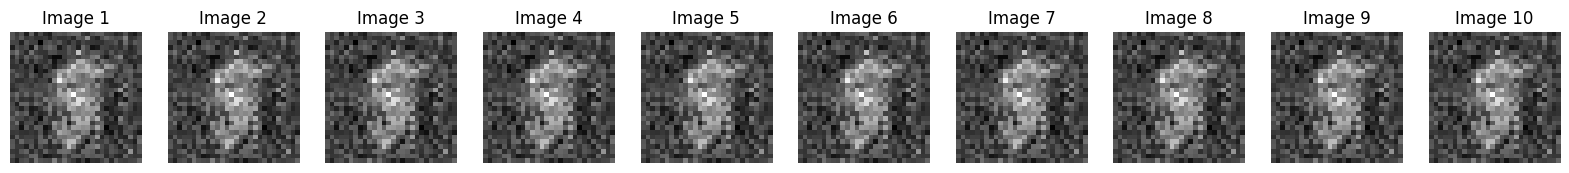

In [16]:
convergence(autoencoder)

The pre-training did not end up with a significant representation of the data, though as we can see from the image, it seems to be getting a grasp on where most digits are located –i.e. in the center of the image.

To improve the perfomance, we are now fine-tuning the model, precisely we are let the model train for some other epochs until it starts to overfit (using early stopping to prevent it). Notice that the weights do not reset, rather they are set from the pre-training.

In [17]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
autoencoder.fit(x_train_noisy, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [18]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

Restoring model weights from the end of the best epoch: 19.
Epoch 24: early stopping
313/313 [==============================] - 1s 2ms/step - loss: 0.3873 - accuracy: 0.8765
Test accuracy: 0.8765000104904175, Test loss: 0.38725772500038147


In [ ]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

The accuracy did improve significantly w.r.t. the pre-trained model, but just a little in comparison to the previous auto-encoder, the one that has been trained without GULP.

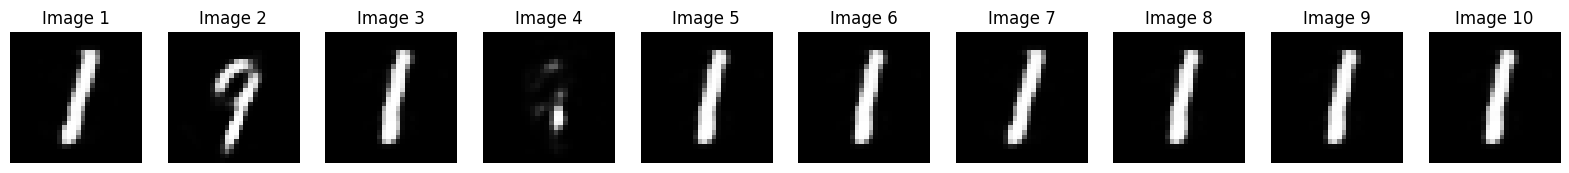

In [19]:
convergence(autoencoder)

Once again, the model seems to have learned a representation of the data as the random noise image converges to some digits, specifically 9 and 1 (same as before).

### Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [ ]:
(train_images_2D, _), (test_images_2D, _) = mnist.load_data()

train_images_2D = train_images_2D.astype('float32') / 255.
test_images_2D = test_images_2D.astype('float32') / 255.

train_images_2D = np.reshape(train_images_2D, (len(train_images_2D), 28, 28, 1))
test_images_2D = np.reshape(test_images_2D, (len(test_images_2D), 28, 28, 1))

x_train_noisy_2D = train_images_2D + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images_2D.shape)
x_test_noisy_2D = test_images_2D + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images_2D.shape)

x_train_noisy_2D = np.clip(x_train_noisy_2D, 0., 1.)
x_test_noisy_2D = np.clip(x_test_noisy_2D, 0., 1.)

In [20]:
input_img = K.layers.Input(shape=(28, 28, 1))
# encoder
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = K.layers.MaxPooling2D((2, 2), padding='same')(x)
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = K.layers.MaxPooling2D((2, 2), padding='same')(x)

# decoder
x = K.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = K.layers.UpSampling2D((2, 2))(x)
x = K.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = K.layers.UpSampling2D((2, 2))(x)
decoded = K.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = K.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
autoencoder.fit(x_train_noisy_2D, train_images_2D, epochs=50, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

Restoring model weights from the end of the best epoch: 38.
Epoch 43: early stopping


In [21]:
# extracting the encoder part from the trained autoencoder
autoencoder_input = K.layers.Input(shape=(28, 28, 1))
x = autoencoder.layers[1](autoencoder_input)  # first Conv2D layer
x = autoencoder.layers[2](x)  # first MaxPooling2D layer
x = autoencoder.layers[3](x)  # second Conv2D layer
encoded_output = autoencoder.layers[4](x)  # second MaxPooling2D layer

# logistic regressor
flatten = K.layers.Flatten()(encoded_output)
dense = K.layers.Dense(128, activation='relu')(flatten)
classifier_output = K.layers.Dense(10, activation='softmax')(dense)
classifier_model = K.Model(autoencoder_input, classifier_output)

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.fit(x_train_noisy_2D, train_labels, epochs=30, batch_size=256, validation_split=0.2, verbose=0)

test_loss, test_accuracy = classifier_model.evaluate(x_test_noisy_2D, test_labels, verbose=0)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

Test accuracy: 0.9678000211715698, Test loss: 0.18384641408920288


In [ ]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

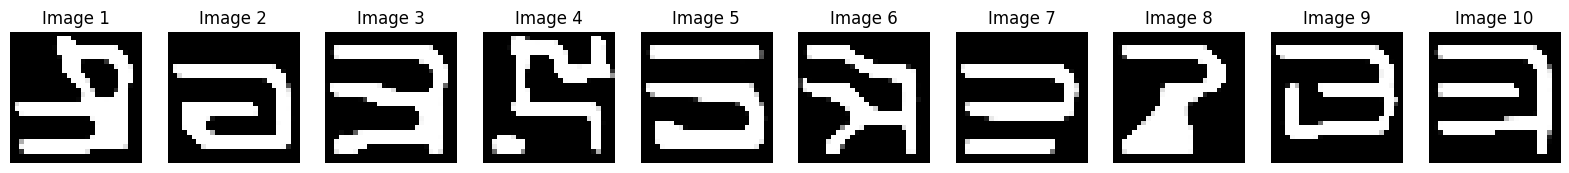

In [24]:
convergence(autoencoder, conv=True)

The accuracy surely gets better than the previous models, but the reconstructions are the weirdest looking ones so far.

# Contractive Auto Encoder
Up to now, we have limited ourselves to using a noising process to determine our training.

CAEs act similar to DAEs but with a slight difference: the formers specifically penalize the derivative of the hidden representation with respect to the input – meaning how much the internal representation changes in response to small changes in the input (focusing on the stability and robustness of the features themselves); while the latters focus on recovering an accurate, denoised version of the input from a deliberately corrupted version, thus encouraging the model to learn the more stable, structural characteristics of the data rather than noise.


In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

train_labels = K.utils.to_categorical(train_labels, 10)
test_labels = K.utils.to_categorical(test_labels, 10)

In [67]:
def frob_J_encoder(model, input):
    f_enc = model(input)
    weights = tf.transpose(model.layers[-1].weights[0])
    return tf.reduce_sum((f_enc * (1-f_enc))**2 * tf.reduce_sum(weights**2, axis=1), axis=1)

def contractive_loss(encoder, lam=1e-4):
    def loss(y_true, y_pred):
        mse = K.backend.mean(K.backend.square(y_true - y_pred), axis=-1)
        return mse + lam * frob_J_encoder(encoder, y_true)
    return loss

In [29]:
def frob_J_encoder(model, input_data):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        f_enc = model(input_data)
    
    J = tape.jacobian(f_enc, input_data)
    return tf.norm(J, ord='fro', axis=(1, 2))

def contractive_loss(encoder, lam=1e-4):
    def loss(y_true, y_pred):
        mse = K.backend.mean(K.backend.square(y_true - y_pred), axis=-1)
        return mse + lam * frob_J_encoder(encoder, y_true)
    return loss

In [ ]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
encoded = K.layers.Dense(256, activation='sigmoid')(input_img)
encoded = K.layers.Dense(128, activation='sigmoid')(encoded)
decoded = K.layers.Dense(256, activation='sigmoid')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

custom_loss = contractive_loss(encoder)
autoencoder.compile(optimizer='adam', loss=custom_loss)

# autoencoder's training
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
autoencoder.fit(train_images, train_images, epochs=30, batch_size=256, shuffle=True, validation_split=0.2, verbose=1, callbacks=[early_stopping])

In [ ]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

In [88]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.008153810165822506


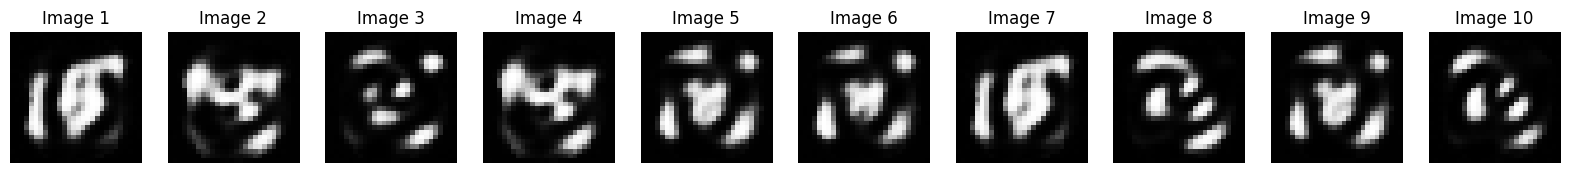

In [89]:
convergence(autoencoder)

tf.Tensor(6.337863e-07, shape=(), dtype=float32)


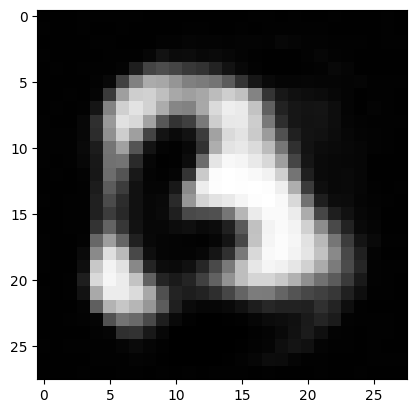

In [60]:
noise_image = np.random.normal(loc=0, scale=1, size=(1, 784))
noise_image = np.clip(noise_image, 0., 1.)
prev = 0
for _ in range(800):
    noise_image = autoencoder.predict(noise_image, verbose=0)
    distance = tf.norm(noise_image - prev)
    prev = noise_image

print(distance)
plt.imshow(noise_image.reshape(28, 28), cmap='gray')
plt.show()

In [84]:
# define the autoencoder structure
def create_autoencoder(input_size, encoding_dim):
    input_layer = K.layers.Input(shape=(input_size,))
    encoded = K.layers.Dense(encoding_dim, activation='sigmoid')(input_layer)
    decoded = K.layers.Dense(input_size, activation='sigmoid')(encoded)
    autoencoder = K.Model(input_layer, decoded)
    encoder = K.Model(input_layer, encoded)
    custom_loss = contractive_loss(encoder)
    autoencoder.compile(optimizer='adam', loss=custom_loss)
    return autoencoder

# layerwise pretraining
first_autoencoder = create_autoencoder(784, 256)
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
first_autoencoder.fit(train_images, train_images, epochs=20, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# get the encoder
first_encoder = K.Model(first_autoencoder.input, first_autoencoder.layers[1].output)
first_encoded_train = first_encoder.predict(train_images, verbose=0)

second_autoencoder = create_autoencoder(256, 128)
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
second_autoencoder.fit(first_encoded_train, first_encoded_train, epochs=20, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# stacking up the full autoencoder
input_img = K.layers.Input(shape=(784,))
first_encoded = first_autoencoder.layers[1](input_img)
second_encoded = second_autoencoder.layers[1](first_encoded)
second_decoded = second_autoencoder.layers[2](second_encoded)
first_decoded = first_autoencoder.layers[2](second_decoded)

autoencoder = K.Model(input_img, first_decoded)
encoder = K.Model(input_img, second_encoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/20
118/188 [=================>............] - ETA: 1s - loss: 0.0718

KeyboardInterrupt: 

In [69]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.2947 - accuracy: 0.9157
Test accuracy: 0.9157000184059143, Test loss: 0.29471686482429504


In [70]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.006373838521540165


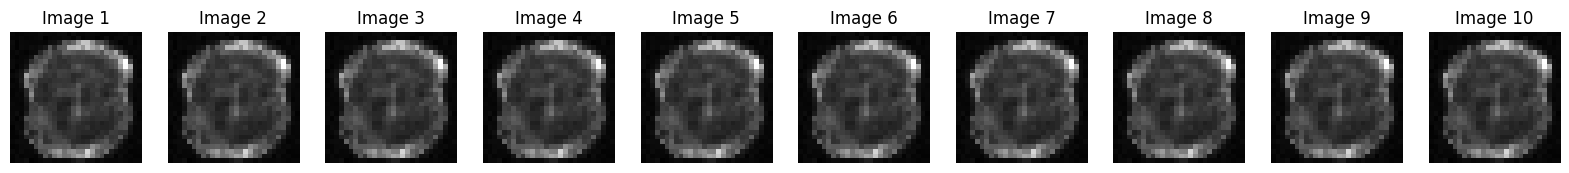

In [71]:
convergence(autoencoder, n_img=10)

In [72]:
# fine-tuning the full autoencoder
early_stopping = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, restore_best_weights=True)
autoencoder.fit(train_images, train_images, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping], verbose=0)

Restoring model weights from the end of the best epoch: 34.
Epoch 39: early stopping


In [79]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(train_images, verbose=0)
encoded_test_images = encoder.predict(test_images, verbose=0)

log_reg(encoded_train_images, train_labels, encoded_test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.3123 - accuracy: 0.9133
Test accuracy: 0.9132999777793884, Test loss: 0.31230294704437256


In [81]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(test_images, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.003314527915790677


The accuracy did improve significantly w.r.t. the pre-trained model, but just a little in comparison to the previous auto-encoder, the one that has been trained without GULP.

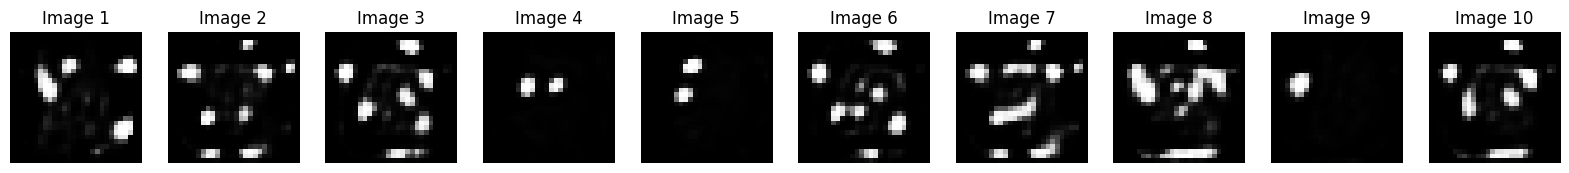

In [82]:
convergence(autoencoder)